# Import Modules

In [58]:
%matplotlib inline
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import random
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from hyperopt import fmin, tpe, hp
import time
import copy
import os
from torchvision.utils import save_image


# Check Available Devices


In [59]:
if torch.cuda.is_available:
  avDev = torch.device("cuda")
else:
  avDev = torch.device("cpu")
print(avDev)

cuda


# Set Seed

In [60]:
seed = 1
torch.manual_seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic=True

# Utility for Displaying Images, Error Curve

In [61]:
def showImagesWithTargets(img,targets):
    img = img / 2 + 0.5     # unnormalize
    img = img.numpy()
    plt.imshow(img.transpose((1,2,0)))
    plt.show()
    targets=targets.numpy()
    plt.imshow(targets.transpose((1,2,0)))
    plt.show()

In [62]:
#Visualise segmented output
def visualiseSegmented(segmentedImage,iter):
    colorMap = [[0,0,0],[0,0,255],[255,255,255]]
    size = segmentedImage.size()
    segImage = np.empty([3,size[0],size[1]])
    for i in range(size[0]):
        for j in range(size[1]):
            color = colorMap[segmentedImage[i][j]]
            for k in range(3):
                segImage[k,i,j] = color[k]
    segImage = segImage.transpose((1,2,0))
    plt.imshow(segImage)
    plt.savefig('./outputs/segmented/img[' + str(iter) + '].png')
    plt.show()

In [63]:
def plot_error_curve(errors):
  plt.suptitle('Learning Curve', fontsize=20)
  plt.xlabel('Iterations', fontsize=18)
  plt.ylabel('Classification Error', fontsize=16)
  plt.plot(np.array(errors))

# Load Data Functions

In [64]:
def transformations(listTransforms):
    return transforms.Compose(listTransforms)

In [65]:
class CudaVisionDataset(Dataset):

    def __init__(self, dir_path,transform=None):
        super(CudaVisionDataset, self).__init__()
        self.img_paths,self.target_paths = read_files(img_dir_path=dir_path)
        self.transform = transform
          
    def __getitem__(self, index):
        
        input_img = plt.imread(self.img_paths[index])
        # print(img.shape) # Shape is l x w x c
        #input_img = input_img.reshape(3,480,640)
        #input_img = torch.Tensor(input_img)
        target_img = plt.imread(self.target_paths[index])
        #target_img = target_img.reshape(3,480,640)
        #target_img = torch.Tensor(target_img)
        
        #showImagesWithTargets(input_img,target_img)
        if self.transform != None :
            
            trnfm_input = transformations(self.transform)
            trnfm_target= transformations(self.transform)
            input_img = trnfm_input(input_img)
            target_img  = trnfm_target(target_img)
            #print(input_img.shape,target_img.shape)
        return input_img,target_img

    def __len__(self):
        return len(self.target_paths)

In [66]:
def read_files(img_dir_path):
    img_paths = []
    target_paths = []
    if os.path.isdir(img_dir_path):
        print("Folder exists. Reading..")
    dir = os.path.join(img_dir_path,'input')
    for r, _, f in os.walk(dir):
        for file in f:
            img_paths.append(os.path.join(r, file))
            
    if len(img_paths) == 0:
        print("No Images in given path available. Check directory or format.")
    dir = os.path.join(img_dir_path,'output')
    for r, _, f in os.walk(dir):
        for file in f:
            target_paths.append(os.path.join(r, file))
    if len(target_paths) == 0:
        print("No Images in given path available. Check directory or format.")
    
    return img_paths,target_paths

# Hyperparameter

## 

In [67]:
lr = 0.0001
batchSize = 20
epoch = 200
tv_weight = 0.2


# Load Data And Make Iterable

In [68]:
listTransforms = [transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])]

In [69]:
class CudaVisionDataLoader:

    def __call__(self, dir_path='./small_data', transform=None,batch_size=20):
        dataset = CudaVisionDataset(dir_path,transform)
        return DataLoader(dataset,batch_size=batch_size, shuffle=True)

In [70]:
#listTransforms = [transforms.RandomHorizontalFlip(0.5),
 #       transforms.ToTensor(),
  #      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))]
#transforms(listTransforms)
data = CudaVisionDataLoader()
parentDir = './small_data'
dirDetectionDataset = os.path.join(parentDir,'detection')
dirSegmentationDataset = os.path.join(parentDir,'segmentation')
train_loader_detection = data.__call__(os.path.join(dirDetectionDataset,'train'),listTransforms,batchSize)
test_loader_detection = data.__call__(os.path.join(dirDetectionDataset,'test'),listTransforms,batchSize)
train_loader_segmentation = data.__call__(os.path.join(dirSegmentationDataset,'train'),listTransforms,batchSize)
test_loader_segmentation = data.__call__(os.path.join(dirSegmentationDataset,'test'),listTransforms,batchSize)


Folder exists. Reading..
Folder exists. Reading..
Folder exists. Reading..
Folder exists. Reading..


In [71]:
dataiter_detection = train_loader_detection.__iter__()

dataiter_segmentation = train_loader_segmentation.__iter__()


# Model Definition

In [72]:
class ResNet18(nn.Module):
    def __init__(self, original_model, outputs_indices):
        super(ResNet18, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-2])
        self.outputs_indices = [0] + outputs_indices
        print(self.outputs_indices)

    def forward(self, x):
        out = []

        for i in range(len(self.outputs_indices) - 1):
            x = self.features[self.outputs_indices[i]:self.outputs_indices[i + 1]](x)
            out.append(x)
        return out


class soccerSegment(nn.ModuleList):
    def __init__(self, resnet18, outputs_indices, skips_arch, deconvs_arch, bn_arch, last_layer_arch):
        super(soccerSegment, self).__init__()
        self.resnet18 = ResNet18(resnet18, outputs_indices)
        
        # skips_arch = [64, 128, 256, 256, 0]
        # deconvs_arch = [512, 256, 256, 128]
        # bn_arch = [512, 512, 256]
        # last_layer_arch = 256
        self.skips = nn.ModuleList(
            [nn.Conv2d(skips_arch[i], skips_arch[i + 1], kernel_size=1, stride=1, padding=0) for i in
             range(len(skips_arch) - 2)])

        self.deconvs = nn.ModuleList(
            reversed([nn.ConvTranspose2d(deconvs_arch[i] + skips_arch[len(skips_arch) - i - 1], deconvs_arch[i + 1],
                                         kernel_size=2, stride=2, padding=0) for i in
                      range(len(deconvs_arch) - 1)]))

        self.bns = nn.ModuleList(
            [nn.BatchNorm2d(num_features=bn_arch[i]) for i in
             reversed(range(len(bn_arch)))])
        self.relu = nn.ReLU()

        self.conv_det = nn.Conv2d(last_layer_arch, 3, kernel_size=1, stride=1, padding=0)
        self.conv_seg = nn.Conv2d(last_layer_arch, 3, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        skip_links = self.resnet18(x)

        for i in reversed(range(len(skip_links))):
            if i == len(skip_links) - 1:
                skip_links[i - 1] = torch.cat(
                    (self.skips[i - 1](skip_links[i - 1]), self.deconvs[i - 1](self.relu(skip_links[i]))),
                    1)
            elif i == 0:
                skip_links[i] = self.relu(self.bns[i](skip_links[i]))
            else:
                skip_links[i - 1] = torch.cat(
                    (self.skips[i - 1](skip_links[i - 1]),
                     self.deconvs[i - 1](self.relu(self.bns[i](skip_links[i])))),
                    1)
        seg = self.conv_seg(skip_links[i])
        det = self.conv_det(skip_links[i])
        return seg, det

# Training Cycle

In [73]:
#Metrics 

def segmentationAccuracy(segmented,targets):
    sizes = segmented.size()
    
    total_pixel = sizes[0] * sizes[2] *sizes[3]
    
    segmented = torch.argmax(segmented, 1)
    difference = torch.abs(segmented-targets)
    same =(difference==0).sum()
    
    accuracy = (same.item())/total_pixel *100
    return accuracy
    


In [74]:
class TVLoss(nn.Module):
    def __init__(self,TVLoss_weight=1):
        super(TVLoss,self).__init__()
        self.TVLoss_weight = TVLoss_weight

    def forward(self,x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h = self._tensor_size(x[:,:,1:,:])
        count_w = self._tensor_size(x[:,:,:,1:])
        h_tv = torch.pow((x[:,:,1:,:]-x[:,:,:h_x-1,:]),2).sum()
        w_tv = torch.pow((x[:,:,:,1:]-x[:,:,:,:w_x-1]),2).sum()
        return self.TVLoss_weight*2*(h_tv/count_h+w_tv/count_w)/batch_size

    def _tensor_size(self,t):
        return t.size()[1]*t.size()[2]*t.size()[3]

In [ ]:
#Training cycle without hyperopt
def train():
    import torchvision.models as models
    resnet18  = models.resnet18(pretrained=True)
    model = soccerSegment(resnet18,[5,6,7,8],[64, 128, 256, 256, 0],[512, 256, 256, 128],[512, 512, 256],256)
    #if torch.cuda.is_available():
     #   model.cuda()
    iter = 0
    criterionDetection = nn.MSELoss()
    criterionSegmented = nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    
    for num in range(2):
        try:
            images, targets = dataiter_detection.next()
          #  if torch.cuda.is_available():
           #     images = images.cuda()
            #    targets = targets.cuda()

        except:
            dataiter_detection = train_loader_detection.__iter__()
            images,targets = dataiter_detection.next()
          # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

          # Forward pass to get output
        detected,segmented = model(images)
        imageToSave = detected[0]
        imageToSave = imageToSave.detach().numpy()
        save_image(detected[0], './img[' + str(iter) + '].png')
        loss = criterionDetection(detected, targets)
        addition = TVLoss(tv_weight)
        lossTV = addition(targets)
        total_loss = loss + lossTV
          # Getting gradients w.r.t. parameters
        loss.backward()

          # Updating parameters
        optimizer.step()
        try:
            images,targets = dataiter_segmentation.next()
            #if torch.cuda.is_available():
             #   images = images.cuda()
              #  targets = targets.cuda()
        except:
            dataiter_segmentation = train_loader_segmentation.__iter__()
            images,targets = dataiter_segmentation.next()
          

          # Forward pass to get output
        detected,segmented = model(images)
        target = torch.argmax(targets, 1)
        loss = criterionSegmented(segmented, target)
        showImagesWithTargets(images[0],targets[0])
          # Getting gradients w.r.t. parameters
        loss.backward()

          # Updating parameters
        optimizer.step()
        iter += 1
        losses =0
        if iter % 1 == 0:
              # Iterate through test dataset
            for images, targets in test_loader_detection:
                  #######################
                  #  USE GPU FOR MODEL  #
                  #######################
               # if torch.cuda.is_available():
                #    images = images.cuda()

                  # Forward pass only to get logits/output

                detected,segmented = model(images)


                  # Total number of labels
                loss=criterionDetection(detected, targets)
                losses = losses+loss.item()    

              # Print Loss
            print('Loss Detection: {}.', loss.item())
            
            losses =0
            for images, targets in test_loader_segmentation:
                  #######################
                  #  USE GPU FOR MODEL  #
                  #######################
                #if torch.cuda.is_available():
                    #images = images.cuda()

                  # Forward pass only to get logits/output
                #print(targets[0][0])
                detected,segmented = model(images)


                  # Total number of labels
                target = torch.argmax(targets, 1)
                loss=criterionSegmented(segmented, target)
                losses = losses+loss.item()    

              # Print Loss
            print('Loss Segmentation: {}.', loss.item())
            accuracy =segmentationAccuracy(segmented,target)
            print('Segmentation Accuracy: {}.',accuracy)
            #Save some images to check
            segmented = torch.argmax(segmented, 1)
            visualiseSegmented(segmented[0],iter)
            

[0, 5, 6, 7, 8]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


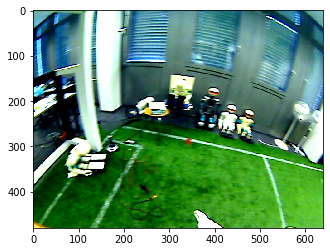

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


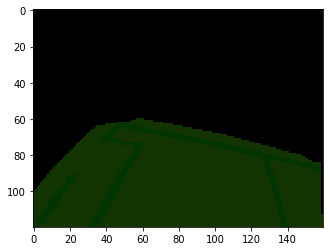

Loss Detection: {}. 5.038052558898926
Loss Segmentation: {}. 0.12186496704816818
Segmentation Accuracy: {}. 33.046875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


FileNotFoundError: [Errno 2] No such file or directory: './outputs/segmented/img[1].png'

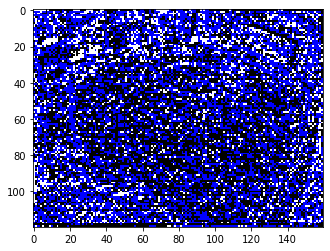

In [80]:
train()

In [ ]:
def train(args):   #Consist of all args from hyperopt
    
    return loss.item()

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    return model

# Hyperopt

In [ ]:
optimizers = [torch.optim.SGD, torch.optim.Adam, torch.optim.Adagrad, torch.optim.Adadelta, torch.optim.RMSprop]
regularizers = ['l1','l2']
space = [hp.choice('optimizer',optimizers),hp.choice('regularizer',regularizers)]
best_classifier = fmin(train,space,algo=tpe.suggest,max_evals=30)
optimizer = optimizers[int(best_classifier['optimizer'])]
regularizer = regularizers[int(best_classifier['regularizer'])]


In [ ]:
#Use the best found optimizer and criterion
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25)

# Visualization of Results

In [ ]:
#I think this got covered 

# Metric Measures

In [ ]:
def seg_iou(ground_truth, predicted, classes):
    avg_iou = 0
    for c in classes:
        gt = np.all(ground_truth == c, axis=-1)
        pr = np.all(predicted == c, axis=-1)
        intersection = np.logical_and(gt, pr)
        union = np.logical_or(gt, pr)
        iou_score = np.sum(intersection) / np.sum(union)

        avg_iou += iou_score
    return avg_iou